Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim
# C:\Users\Yolo\AppData\Roaming\Python\Python36\site-packages\skimage\measure\simple_metrics.py
# from skimage.measure.simple_metrics import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

def calculate_mse(image_true, image_test):
    """计算均方误差（MSE）"""
    return np.mean((image_true - image_test) ** 2)

def compare_psnr(image_true, image_test, data_range=None):
    """
    计算峰值信噪比（PSNR）。
    
    参数:
    - image_true: 真实的图像（numpy 数组）。
    - image_test: 测试的图像（numpy 数组）。
    - data_range: 图像数据类型可能的最大值，默认为 255 对于 8 位图像。
    
    返回:
    - psnr_value: 计算得到的 PSNR 值。
    """
    if data_range is None:
        # 假设图像是 8 位的，最大值为 255
        data_range = 255.0
    
    mse = calculate_mse(image_true, image_test)
    if mse == 0:
        # MSE 为 0 意味着两个图像完全相同，PSNR 为无穷大
        return float('inf')
    
    psnr_value = 20 * np.log10(data_range / np.sqrt(mse))
    return psnr_value

In [4]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

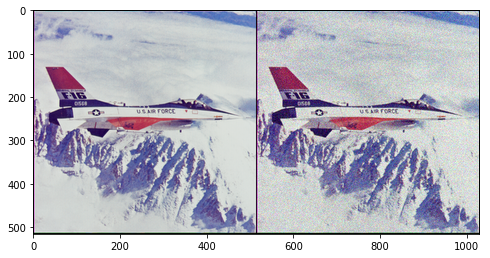

In [5]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [6]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()])
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

Starting optimization with ADAM


c:\users\yolo\.conda\envs\dip_py36\lib\site-packages\torch\nn\functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


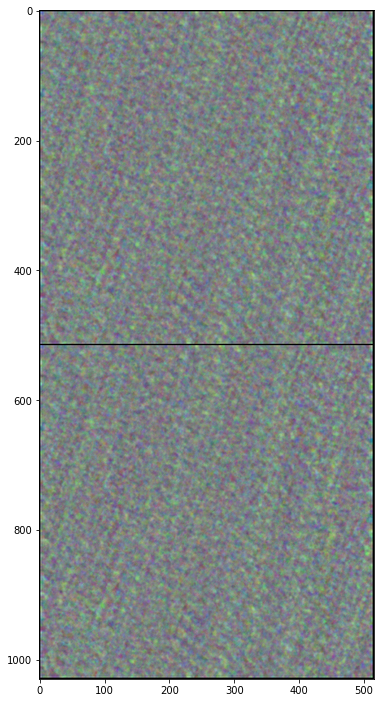

Falling back to previous checkpoint.SNR_noisy: 53.837964   PSRN_gt: 53.975831 PSNR_gt_sm: 59.310915 
PSNR_gt_sm: 59.315297  Iteration 00006    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00008    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00011    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00013    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00018    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00021    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00024    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan   Iteration 00029    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00031    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00033    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00035    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00037    Loss na

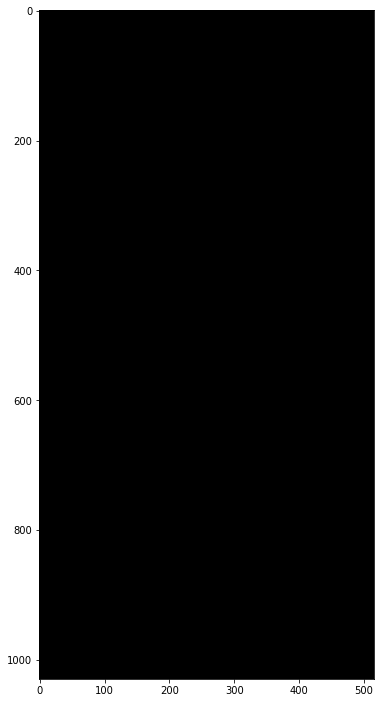

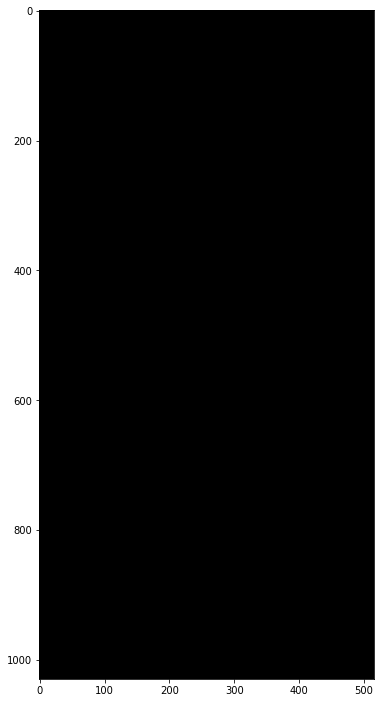

 Iteration 00213    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00217    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00219    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00221    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00224    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan    Iteration 00230    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00232    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00236    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00238    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00240    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan Iteration 00242    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00245    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_gt_sm: nan  Iteration 00248    Loss nan   PSNR_noisy: nan   PSRN_gt: nan PSNR_g

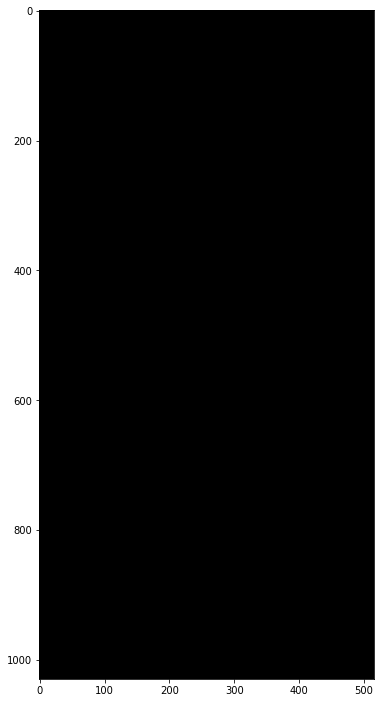

KeyboardInterrupt: 

In [7]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);